In [52]:
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
import holidays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf

In [53]:
tf.test.is_gpu_available()

False

In [54]:
#Tensorflow GPU memory management
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[]

In [55]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [56]:
# Load the dataset from a CSV file
df = pd.read_csv("df_time_serie_2022.csv")

# Convert the 'FECHA' column to datetime format
df.FECHA = pd.to_datetime(df.FECHA)

# Set the 'FECHA' column as the index
df.set_index("FECHA", inplace=True)

In [57]:
# Add day of the week
df["Dia de la semana"] = df.index.dayofweek

# Add 'Mañana' if hour < 8
df["Mañana"] = 0
df.loc[df.index.hour < 8, "Mañana"] = 1

# Add 'Tarde' if 8 <= hour < 16
df["Tarde"] = 0
df.loc[(df.index.hour >= 8) & (df.index.hour < 16), "Tarde"] = 1

# Add 'Noche' if hour >= 16
df["Noche"] = 0
df.loc[df.index.hour >= 16, "Noche"] = 1

# Add holidays from Mexico
mex_holidays = holidays.MX(years=[2022, 2023, 2024])

# Add holidays from Mexico, if it is a holiday set 'Feriado' to 1
df["Feriado"] = 0
for date in mex_holidays.keys():
    df.loc[df.index.date == date, "Feriado"] = 1

# Add non-working days in Mexico
df["Dia laboral"] = 1
df.loc[(df.index.month == 1) & (df.index.day < 6), "Dia laboral"] = 0
df.loc[(df.index.month == 4) & (df.index.day > 11) & (df.index.day < 27), "Dia laboral"] = 0
df.loc[(df.index.month == 12) & (df.index.day > 19), "Dia laboral"] = 0
df.loc[(df.index.month == 7) & (df.index.day > 16), "Dia laboral"] = 0
df.loc[(df.index.month == 8) & (df.index.day < 26), "Dia laboral"] = 0

# Create exogenous variables dataframe
exog = df[["Dia de la semana", "Mes", "Dia", "Hora", "Mañana", "Tarde", "Noche", "Feriado", "Dia laboral"]]

# Drop the columns from the main dataframe
df.drop(columns=["Dia de la semana", "Mes", "Dia", "Hora", "Mañana", "Tarde", "Noche", "Feriado", "Dia laboral"], inplace=True)

# Add day of the month
exog["Dia del mes"] = exog.index.day

# Convert categorical variables to dummy variables
exog = pd.get_dummies(exog, columns=["Dia de la semana", "Mes"])

# Convert time-related features to cyclic features
exog["hour_cos"] = np.cos(2 * np.pi * exog["Hora"] / 24)
exog["hour_sin"] = np.sin(2 * np.pi * exog["Hora"] / 24)
exog["day_cos"] = np.cos(2 * np.pi * exog["Dia del mes"] / 31)
exog["day_sin"] = np.sin(2 * np.pi * exog["Dia del mes"] / 31)
exog["Dia del año cos"] = np.cos(2 * np.pi * exog["Dia"] / 365)
exog["Dia del año sin"] = np.sin(2 * np.pi * exog["Dia"] / 365)

# Drop unnecessary columns
exog.drop(columns=["Hora", "Dia del mes", "Dia"], inplace=True)

# Ensure the dataframes have hourly frequency
df = df.asfreq("h")
exog = exog.asfreq("h")

# Convert boolean columns to integers
exog = exog.astype(int)

C:\Users\jesus\AppData\Local\Temp\ipykernel_24768\2143946489.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["Dia del mes"] = exog.index.day


In [58]:
df = pd.concat([df, exog], axis=1)
df

,SURESTE CO (PPM),SURESTE NO (PPB),SURESTE NO2 (PPB),SURESTE NOX (PPB),SURESTE O3 (PPB),SURESTE PM10 (UG/M3),SURESTE PM2.5 (UG/M3),SURESTE PRS (MMHG),SURESTE RAINF (MM/HR),SURESTE RH (%),...,Mes_9.0,Mes_10.0,Mes_11.0,Mes_12.0,hour_cos,hour_sin,day_cos,day_sin,Dia del año cos,Dia del año sin
FECHA,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,2.36,19.800000,48.4,68.0,5.0,142.000000,32.453919,715.7,0.0,59.0,...,0,0,0,0,1,0,0,0,0,0
2022-01-01 01:00:00,2.29,10.800000,44.5,55.1,6.0,72.001904,26.974146,715.5,0.0,59.0,...,0,0,0,0,0,0,0,0,0,0
2022-01-01 02:00:00,2.71,28.300000,47.1,75.2,4.0,69.883318,26.580326,715.4,0.0,62.0,...,0,0,0,0,0,0,0,0,0,0
2022-01-01 03:00:00,2.31,19.600000,42.1,61.5,5.0,60.497876,24.535997,715.1,0.0,59.0,...,0,0,0,0,0,0,0,0,0,0
2022-01-01 04:00:00,1.85,13.000000,39.5,52.5,4.0,78.454611,31.329770,715.1,0.0,59.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,0.67,3.034592,4.3,7.5,26.0,88.000000,14.399414,721.7,0.0,48.0,...,0,0,0,0,0,0,1,0,0,0
2024-07-31 20:00:00,0.66,2.900000,4.5,7.4,24.0,94.000000,16.468888,721.8,0.0,49.0,...,0,0,0,0,0,0,1,0,0,0
2024-07-31 21:00:00,0.65,2.700000,3.9,6.6,24.0,83.000000,20.688715,722.1,0.0,50.0,...,0,0,0,0,0,0,1,0,0,0


In [60]:
# Preparar los datos para el modelo de red neuronal
df.index = pd.to_datetime(df.index)
X = df.drop(['SURESTE PM2.5 (UG/M3)'], axis=1)
y = df['SURESTE PM2.5 (UG/M3)']

# Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

end_train = '2024-07-10 23:00:00'

# Calculate the date to start the predictions automatically
start_pred = pd.to_datetime(end_train) + pd.Timedelta(hours=1)

# Now split the data using the datetime index
X_train = X.loc[:end_train].copy()
X_test  = X.loc[start_pred:].copy()
y_train = y.loc[:end_train].copy()
y_test  = y.loc[start_pred:].copy()

print(f"Train dates      : {X_train.index.min()} --- {X_train.index.max()}  (n={len(X_train)})")
print(f"Test dates       : {X_test.index.min()} --- {X_test.index.max()}  (n={len(X_test)})")

# Normalizar las características
scaler = StandardScaler()

# Ajustar el escalador solo en el conjunto de entrenamiento
scaler.fit(X_train)

# Guardar el escalador en un archivo
joblib.dump(scaler, 'scaler.pkl')

# Transformar tanto el conjunto de entrenamiento como el conjunto de prueba
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train dates      : 2022-01-01 00:00:00 --- 2024-07-10 23:00:00  (n=22128)
Test dates       : 2024-07-11 00:00:00 --- 2024-07-31 23:00:00  (n=504)


In [61]:
def create_model(learning_rate=0.01, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [62]:
model = KerasRegressor(build_fn=create_model, verbose=0)
param_dist = {'learning_rate': [0.01],
              'dropout_rate': [0.075],
              'epochs': [150],
              'batch_size': [8]}
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, cv=5, n_jobs=-1)
random_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print(random_search.best_params_)

C:\Users\jesus\AppData\Local\Temp\ipykernel_24768\1788443636.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


{'learning_rate': 0.01, 'epochs': 150, 'dropout_rate': 0.075, 'batch_size': 8}


In [64]:
# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred = best_model.predict(X_test)
#Reshape the y_pred array
y_pred = y_pred = y_pred[:,0]

#Calcular el R^2 sin keras
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)
print('R^2:', r2_score(y_test, y_pred))

# Calcular el error cuadrático medio
mse = tf.keras.losses.MeanSquaredError()
print('MSE:', mse(y_test, y_pred).numpy())

# Calcular el error absoluto medio
mae = tf.keras.losses.MeanAbsoluteError()
print('MAE:', mae(y_test, y_pred).numpy())

# Crear un DataFrame para las predicciones y los valores reales
df_predictions = pd.DataFrame(y_pred, columns=['Predicted SURESTE PM2.5 (UG/M3)'])
df_actual = y_test.reset_index(drop=True)
df_comparison = pd.concat([df_actual, df_predictions], axis=1)

df_comparison.head(30)

R^2: 0.6503157366340311
MSE: 19.005081
MAE: 3.1148367


,SURESTE PM2.5 (UG/M3),Predicted SURESTE PM2.5 (UG/M3)
0,8.330000,7.108158
1,7.890000,6.258604
2,6.930000,6.027035
3,5.430000,5.972331
4,5.360000,6.254714
5,6.520000,6.841297
6,8.272775,7.021644
7,7.184769,7.228877
8,7.266313,7.779830
9,10.157516,10.679893


In [65]:
y_test

FECHA
2024-07-11 00:00:00     8.330000
2024-07-11 01:00:00     7.890000
2024-07-11 02:00:00     6.930000
2024-07-11 03:00:00     5.430000
2024-07-11 04:00:00     5.360000
                         ...    
2024-07-31 19:00:00    14.399414
2024-07-31 20:00:00    16.468888
2024-07-31 21:00:00    20.688715
2024-07-31 22:00:00    16.006343
2024-07-31 23:00:00    26.528480
Freq: h, Name: SURESTE PM2.5 (UG/M3), Length: 504, dtype: float64

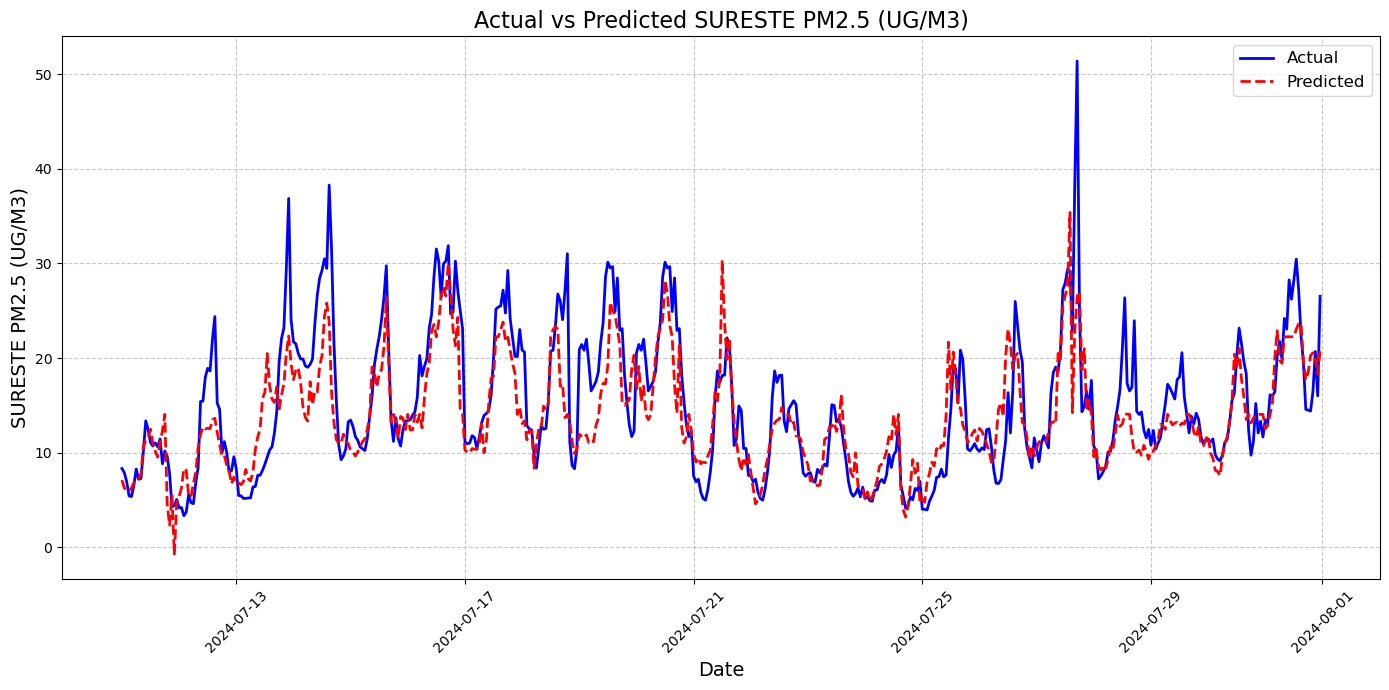

In [67]:
# Graficar las predicciones y los valores reales
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='-', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted SURESTE PM2.5 (UG/M3)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('SURESTE PM2.5 (UG/M3)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [68]:
# Save the best model
best_model.model.save("best_model.h5")